In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pfi.utils import DNN, simulate_ornstein_uhlenbeck, X_from_snapshots
from pfi.score import ScoreMatching

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

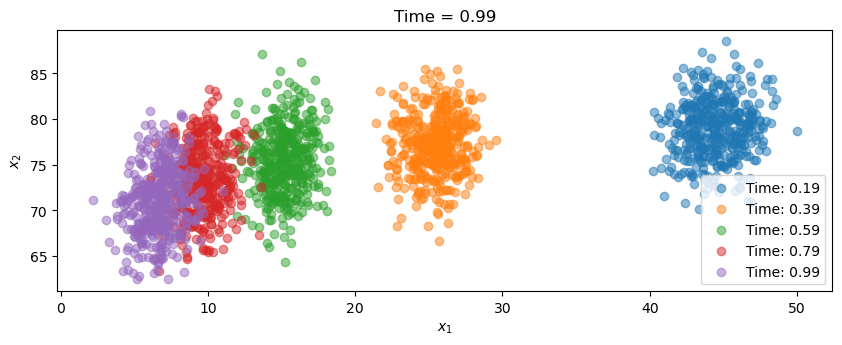

In [2]:
dt = 0.01
Dt = 0.2
nsnaps = 5
nsamples = 4000
D = 5.0
ndim = 2

np.random.seed(7)
A = np.random.randn(2, 2)
B = A @ A.T
eigval, _ = np.linalg.eig(B)

m0 = 80*np.ones((ndim), dtype=np.float32)
S0 = 8.0

samples_full, tt = simulate_ornstein_uhlenbeck(
    Om=B,
    D=D*np.eye(ndim),
    m0=m0,
    S0=S0,
    nsamples=nsamples,
    ndim=ndim,
    Dt=Dt,
    K=nsnaps,
    dt=dt,
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3.4))

for k in range(0, nsnaps):
    ind_s = np.arange(0,samples_full[k].shape[0])
    np.random.shuffle(ind_s)
    ax.scatter(samples_full[k][ind_s[0:400],0],
                samples_full[k][ind_s[0:400],1],
                alpha=0.5,label='Time: '+str(tt[k]))
    ax.legend(loc='best')

    ax.set_title(r'Time = '+ str(np.round(tt[k],3)))
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
plt.show()

In [3]:
X = X_from_snapshots(samples_full, tt)
Np = 50
score_model = DNN([ndim + 2, Np, Np, Np, Np, Np, ndim], activation=nn.ELU()).to(device)

score_reg = ScoreMatching(
    model=score_model,
    solver="dsm",
    solver_kwargs=dict(L=10, lr=1e-2, n_epochs=5000, bs=None, adp_flag=1),
    device=device,
)
score_reg.fit(X)


/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain = torch.tensor(x_train, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xdata = torch.tensor(x_data, dtype=torch.float32).to(device)
DSM:   0%|          | 11/5000 [00:00<01:35, 52.19it/s, lo

epoch: 0 c_: [0.15046597 0.20037653 0.30845976 0.20710312 0.13359463]


DSM:  10%|█         | 511/5000 [00:05<00:47, 94.67it/s, loss=4.796e+00, lr=1.00e-02]

epoch: 500 c_: [0.06524521 0.18964326 0.01856279 0.02125881 0.70528996]


DSM:  20%|██        | 1011/5000 [00:10<00:41, 96.21it/s, loss=4.822e+00, lr=1.00e-02]

epoch: 1000 c_: [0.04858255 0.24140465 0.46961766 0.18108778 0.05930737]


DSM:  30%|███       | 1511/5000 [00:15<00:36, 95.85it/s, loss=4.824e+00, lr=1.00e-02]

epoch: 1500 c_: [0.37559715 0.1662303  0.12524885 0.01885907 0.31406456]


DSM:  40%|████      | 2011/5000 [00:21<00:30, 96.79it/s, loss=4.798e+00, lr=1.00e-02]

epoch: 2000 c_: [0.16488609 0.40452215 0.05437411 0.02286053 0.35335717]


DSM:  50%|█████     | 2511/5000 [00:26<00:25, 96.59it/s, loss=4.802e+00, lr=1.00e-03]

epoch: 2500 c_: [0.20790438 0.2457844  0.11221848 0.02772319 0.40636963]


DSM:  60%|██████    | 3011/5000 [00:31<00:20, 96.07it/s, loss=4.820e+00, lr=1.00e-03]

epoch: 3000 c_: [0.54702693 0.08916999 0.12762272 0.01252019 0.22366014]


DSM:  70%|███████   | 3511/5000 [00:36<00:15, 96.48it/s, loss=4.821e+00, lr=1.00e-03]

epoch: 3500 c_: [0.5836538  0.07534721 0.09736905 0.00860115 0.23502882]


DSM:  80%|████████  | 4011/5000 [00:41<00:10, 96.67it/s, loss=4.821e+00, lr=1.00e-03]

epoch: 4000 c_: [0.590616   0.07137872 0.08605341 0.00678858 0.24516325]


DSM:  90%|█████████ | 4511/5000 [00:46<00:05, 96.90it/s, loss=4.820e+00, lr=1.00e-03]

epoch: 4500 c_: [0.58521456 0.06813723 0.06557664 0.0054877  0.27558395]


DSM: 100%|██████████| 5000/5000 [00:51<00:00, 96.48it/s, loss=4.819e+00, lr=1.00e-03]


/mnt/home/vchardes/pfi/pfi/score/_base.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = torch.tensor(init_, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/_base.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_t, dtype=torch.float32, device=self.device),


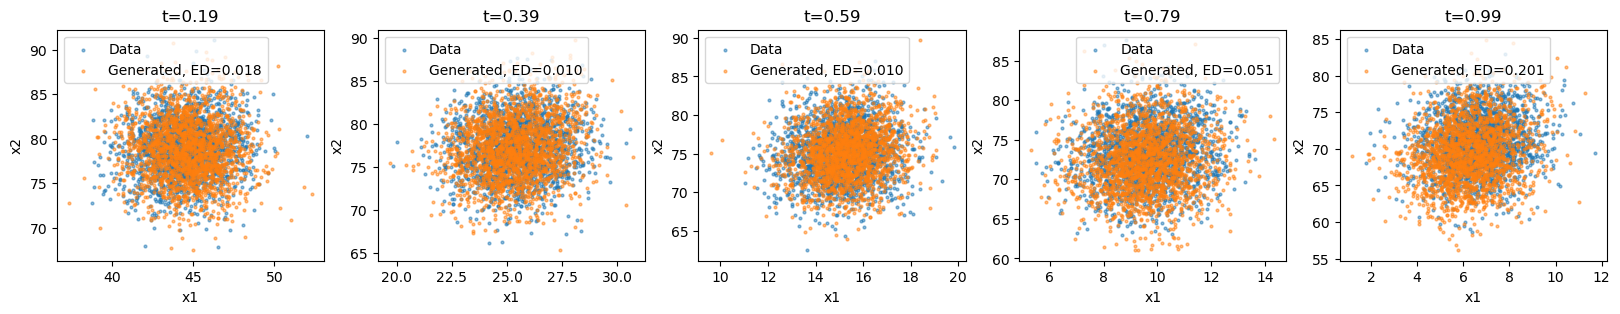

In [4]:
# Sample with ScoreMatching and overlay at each time point
fig, axes = plt.subplots(1, nsnaps, figsize=(4 * nsnaps, 3))
ED = score_reg.score(X)

for k in range(5):
    xk = samples_full[k][:2000]
    Xk = np.hstack([xk, tt[k] * np.ones((xk.shape[0], 1))])
    gen = score_reg.sample(Xk, nsamples=xk.shape[0])

    ax = axes[k]
    ax.scatter(xk[:, 0], xk[:, 1], s=4, alpha=0.5, label="Data")
    ax.scatter(gen[:, 0], gen[:, 1], s=4, alpha=0.5, label="Generated, ED=%.3f" % ED[k])
    ax.set_title(f"t={tt[k]:.2f}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

plt.show()


/mnt/home/vchardes/pfi/pfi/score/_base.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32, device=self.device)


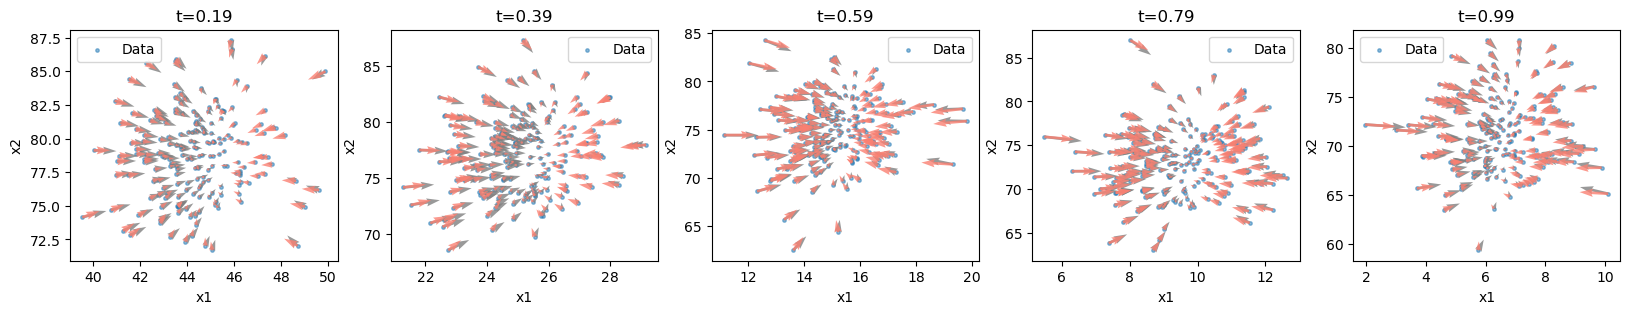

In [5]:
from pfi.score.models import OUScore

true_score = OUScore(
    net=torch.tensor(B, dtype=torch.float32, device=device),
    m0=torch.tensor(m0, dtype=torch.float32, device=device),
    S0=torch.tensor(np.eye(ndim) * S0, dtype=torch.float32, device=device),
    D=torch.tensor(np.eye(ndim) * D, dtype=torch.float32, device=device),
)

rel_err = []
fig, axes = plt.subplots(1, nsnaps, figsize=(4 * nsnaps, 3))

for k in range(5):

    xk = samples_full[k][:200]
    Xk = np.hstack([xk, tt[k] * np.ones((xk.shape[0], 1))])

    Xk = torch.tensor(Xk, dtype=torch.float32, device=device)

    with torch.no_grad():
        pred = score_reg.predict(Xk)
        target = true_score(Xk).cpu().numpy()
    ax = axes[k]
    ax.scatter(xk[:, 0], xk[:, 1], s=6, alpha=0.5, label="Data")
    ax.quiver(xk[:, 0], xk[:, 1], target[:,0], target[:,1], alpha=0.8, width=0.01, scale=20, color='grey', linewidth=2,)
    ax.quiver(xk[:, 0], xk[:, 1], pred[:,0], pred[:,1], alpha=0.8, width=0.01, scale=20, color='salmon', linewidth=2,)

    ax.set_title(f"t={tt[k]:.2f}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

    rel_err.append(np.median(((pred-target)**2).sum(axis=-1)/((target)**2).sum(axis=-1)))

plt.show()


In [6]:
# Interpolant comparison with OUModel + FlowRegression
import numpy as np

from pfi.flow import FlowRegression
from pfi.flow.interpolants import ChebyshevInterpolant, LinearInterpolant, SplineInterpolant
from pfi.flow.models import OUFlow

interpolants = {
    'chebyshev': ChebyshevInterpolant(device=device),
    'spline': SplineInterpolant(device=device),
    'linear': LinearInterpolant(device=device),
}
rel_err = []

for name, interp in interpolants.items():
    B_ = torch.tensor(
            np.zeros((2, 2)), dtype=torch.float32, requires_grad=True, device=device
    )
    D_ = torch.tensor(D * np.eye(ndim),dtype=torch.float32, device=device)
    flow_model = OUFlow(net=B_, 
                        score=score_reg.model_, 
                        D=D_)

    flow_reg = FlowRegression(
        interp=interp,
        model=flow_model,
        growth_model=None,
        solver="fm",
        solver_kwargs=dict(n_epochs=5000, lr=2e-2),
        device=device,
    )
    flow_reg.fit(X)

    B_inf = flow_reg.model_.B.detach().cpu().numpy()
    rel_err.append(np.linalg.norm(B_inf - B) / np.linalg.norm(B))
    print(f'{name}: relative B error = {rel_err[-1]:.4f}')


/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


4000 1000
[lambda-selection] Initial error: 2286.9636
[lambda-selection] Best lambda (>=80% drop): 0.0100
[lambda-selection] Vel magnitudes: [2286.96362305 2259.05712891 2216.28149414 2140.89868164 1965.48291016
 1764.00036621 1621.22680664 1511.87890625 1236.53881836 1076.22338867
  964.19036865  877.86895752  696.30834961  610.52935791]


FM:   0%|          | 0/5000 [00:00<?, ?it/s]/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Dist = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32, device=device)
FM:   0%|          | 25/5000 [00:00<00:19, 249.86it/s, loss=4.250e+00, lr=2.00e-02]

[epoch 0] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  11%|█         | 548/5000 [00:01<00:15, 283.52it/s, loss=5.363e-02, lr=2.00e-02]

[epoch 500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  21%|██        | 1042/5000 [00:03<00:14, 279.26it/s, loss=5.353e-02, lr=2.00e-03]

[epoch 1000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  31%|███       | 1528/5000 [00:05<00:12, 276.28it/s, loss=5.391e-02, lr=2.00e-04]

[epoch 1500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  41%|████      | 2050/5000 [00:07<00:10, 287.65it/s, loss=5.299e-02, lr=2.00e-04]

[epoch 2000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  51%|█████     | 2546/5000 [00:09<00:08, 281.27it/s, loss=5.301e-02, lr=2.00e-04]

[epoch 2500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  61%|██████    | 3040/5000 [00:10<00:07, 279.80it/s, loss=5.313e-02, lr=2.00e-04]

[epoch 3000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  71%|███████   | 3533/5000 [00:12<00:05, 285.60it/s, loss=5.189e-02, lr=2.00e-04]

[epoch 3500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  81%|████████  | 4053/5000 [00:14<00:03, 286.16it/s, loss=5.328e-02, lr=2.00e-04]

[epoch 4000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  91%|█████████ | 4532/5000 [00:16<00:01, 288.21it/s, loss=5.334e-02, lr=2.00e-04]

[epoch 4500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 5000/5000 [00:17<00:00, 282.40it/s, loss=5.338e-02, lr=2.00e-04]


chebyshev: relative B error = 0.0574
4000 1000


FM:   1%|          | 26/5000 [00:00<00:19, 258.27it/s, loss=3.105e+00, lr=2.00e-02]

[epoch 0] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  11%|█         | 529/5000 [00:02<00:17, 258.84it/s, loss=2.272e-01, lr=2.00e-02]

[epoch 500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  21%|██        | 1043/5000 [00:04<00:14, 268.53it/s, loss=2.267e-01, lr=2.00e-03]

[epoch 1000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  31%|███       | 1553/5000 [00:05<00:13, 261.03it/s, loss=2.283e-01, lr=2.00e-04]

[epoch 1500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  41%|████      | 2036/5000 [00:07<00:11, 258.38it/s, loss=2.281e-01, lr=2.00e-04]

[epoch 2000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  51%|█████     | 2552/5000 [00:09<00:09, 262.89it/s, loss=2.275e-01, lr=2.00e-04]

[epoch 2500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  61%|██████    | 3040/5000 [00:11<00:07, 263.69it/s, loss=2.256e-01, lr=2.00e-04]

[epoch 3000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  71%|███████   | 3551/5000 [00:13<00:05, 259.77it/s, loss=2.237e-01, lr=2.00e-04]

[epoch 3500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  81%|████████  | 4035/5000 [00:15<00:03, 261.23it/s, loss=2.266e-01, lr=2.00e-04]

[epoch 4000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  91%|█████████ | 4550/5000 [00:17<00:01, 265.34it/s, loss=2.252e-01, lr=2.00e-04]

[epoch 4500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 5000/5000 [00:19<00:00, 262.01it/s, loss=2.248e-01, lr=2.00e-04]


spline: relative B error = 0.1830
4000 1000


FM:   0%|          | 0/5000 [00:00<?, ?it/s]/mnt/home/vchardes/pfi/pfi/flow/interpolants/_linear.py:51: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /dev/shm/nix-build-py-torch-2.0.1.drv-2/nixbld3/spack-stage-py-torch-2.0.1-6az71ddi5g5hqp90cxh2rbx7im9ynx4k/spack-src/aten/src/ATen/native/BucketizationUtils.h:33.)
  idx = torch.searchsorted(t_fit, t_eval, right=True) - 1
/mnt/home/vchardes/pfi/pfi/flow/interpolants/_linear.py:51: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at /de

[epoch 0] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  11%|█         | 544/5000 [00:01<00:12, 358.66it/s, loss=6.173e-02, lr=2.00e-02]

[epoch 500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  21%|██▏       | 1065/5000 [00:03<00:10, 366.82it/s, loss=6.214e-02, lr=2.00e-03]

[epoch 1000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  31%|███       | 1555/5000 [00:04<00:09, 367.65it/s, loss=6.295e-02, lr=2.00e-04]

[epoch 1500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  41%|████      | 2046/5000 [00:05<00:07, 370.36it/s, loss=6.151e-02, lr=2.00e-04]

[epoch 2000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  51%|█████     | 2537/5000 [00:07<00:06, 360.41it/s, loss=6.190e-02, lr=2.00e-04]

[epoch 2500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  61%|██████    | 3057/5000 [00:08<00:05, 363.66it/s, loss=6.279e-02, lr=2.00e-04]

[epoch 3000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  71%|███████   | 3543/5000 [00:09<00:03, 367.13it/s, loss=6.317e-02, lr=2.00e-04]

[epoch 3500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  81%|████████▏ | 4072/5000 [00:11<00:02, 370.31it/s, loss=6.288e-02, lr=2.00e-04]

[epoch 4000] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM:  91%|█████████ | 4551/5000 [00:12<00:01, 353.95it/s, loss=6.269e-02, lr=2.00e-04]

[epoch 4500] inferred mass=[1.0000004 1.0000004 1.0000004 1.0000004 1.0000004] actual mass=tensor([1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 5000/5000 [00:13<00:00, 364.05it/s, loss=6.252e-02, lr=2.00e-04]

linear: relative B error = 0.2810


dist torch.Size([5, 4000, 2]) batch_ot_samples torch.Size([5, 4000, 2])


/tmp/ipykernel_703336/1853764035.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ot_samples = torch.tensor(batch_ot_samples, dtype=torch.float32)


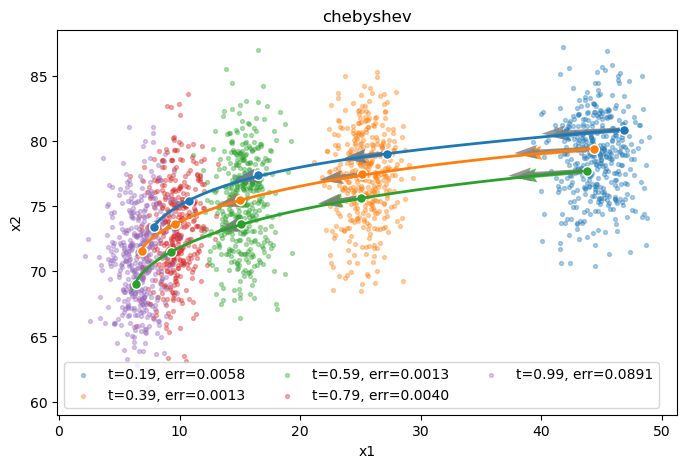

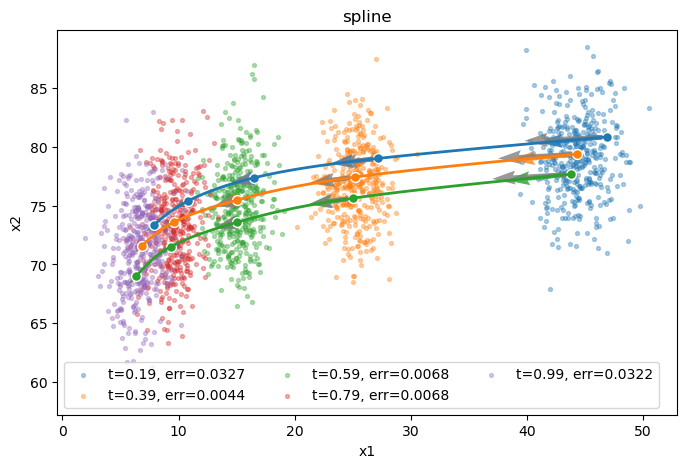

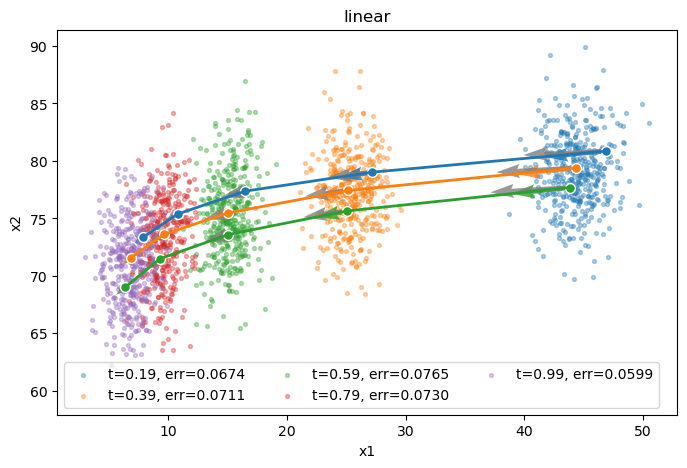

In [7]:
from pfi.flow.interpolants import MMOT_trajectories
from pfi.flow.interpolants import ChebyshevInterpolant, LinearInterpolant, SplineInterpolant
from pfi.utils.data import snapshots_from_X

# Build OT trajectories (MMOT)
np.random.seed(0)
snaps, _ = snapshots_from_X(X)
dist, batch_ot_samples = MMOT_trajectories(snaps)
print('dist', dist.shape, 'batch_ot_samples', batch_ot_samples.shape)

# Nodes of the data and to evaluate the interpolant
npoints = 50
nodes_fit = torch.tensor(tt, dtype=torch.float32)[None, :].repeat(nsamples, 1)
nodes_eval = torch.tensor(np.linspace(tt[0], tt[-1], npoints), dtype=torch.float32)[None, :].repeat(nsamples, 1)

# Data must be in the format nsamples x nsnaps x ndim
batch_ot_samples = torch.tensor(batch_ot_samples, dtype=torch.float32)
dist = torch.permute(batch_ot_samples[:, :, 0:ndim], (1, 0, 2))

interpolants = {
    'chebyshev': ChebyshevInterpolant(),
    'spline': SplineInterpolant(),
    'linear': LinearInterpolant()
}

# Construct the analytical true flow model
X_ = X_from_snapshots([dist.cpu().numpy()[:,k,:] for k in range(nsnaps)], tt)
B_ = torch.tensor(B, dtype=torch.float32)
m0_ = torch.tensor(m0, dtype=torch.float32) 
S0_ = torch.tensor(np.eye(ndim)*S0, dtype=torch.float32)
D_ = torch.tensor(np.eye(ndim)*D, dtype=torch.float32)

true_score = OUScore(net=B_,
                     m0=m0_, 
                     S0=S0_, 
                     D=D_)

true_flow = OUFlow(net=B_,
                   score=true_score,
                   D=D_)

dx_flow = (true_flow(torch.tensor(X_, dtype=torch.float32))
                    .reshape(nsnaps, nsamples, ndim)
                    .permute(1,0,2).detach().cpu().numpy())

for name, interpolant in interpolants.items():

    interpolant.fit(nodes_fit, dist)
    x_train = interpolant.y_fit_.cpu().numpy()

    x_interp, _ = interpolant.predict(nodes_eval)
    _, dx_interp_data = interpolant.predict(nodes_fit)

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    colors = ['tab:blue', 'tab:orange', 'tab:green']


    x_interp = x_interp.cpu().numpy()
    dx_interp_data = dx_interp_data.cpu().numpy()
    average_rel_err = np.mean(((dx_flow - dx_interp_data)**2).sum(axis = -1)/((dx_flow)**2).sum(axis = -1), axis=0)

    for k in range(nsnaps):
        xk = samples_full[k]
        ind = np.arange(xk.shape[0])
        np.random.shuffle(ind)
        ax.scatter(xk[ind[:400], 0], xk[ind[:400], 1], s=8, alpha=0.35, 
                   label='t=%.2f, err=%.4f' % (tt[k], average_rel_err[k]))

    for i in range(3):

        ax.plot(x_interp[i, :, 0], x_interp[i, :, 1], color=colors[i], linewidth=2)
        ax.quiver(x_train[i, :, 0], x_train[i, :, 1],
                 dx_interp_data[i, :, 0], dx_interp_data[i, :, 1], color=colors[i], alpha = 0.8, linewidth=2, scale=1000)
        ax.quiver(dist[i, :, 0].cpu().numpy(), dist[i, :, 1].cpu().numpy(),
                 dx_flow[i, :, 0], dx_flow[i, :, 1], alpha = 0.8, color='grey', linewidth=2, scale=1000)
        ax.scatter(x_train[i, :, 0], x_train[i, :, 1], s=50, color=colors[i], edgecolor='white')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend(loc='best', ncol=3)
    ax.set_title('%s' % (name))
    plt.show()

